# AirSimDataset - Resnet50 - Model training

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from torchsummary import summary
import torchinfo
import json
from torchvision.models.segmentation import fcn
import glob
from PIL import Image
import time
from torch.utils.data import DataLoader
import airsim 

from torch.utils.tensorboard import SummaryWriter

In [2]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda:0")
print("Device chosen GPU:", torch.cuda.get_device_name(device))

# Parameters
num_classes = 3

# Hyper parameters
num_epochs = 50
batch_size = 4
learning_rate = 0.0001
beta1 = 0.9
beta2 = 0.999
log_directory = f"runs/AirSimDataset/resnet50/v0.0.0 Adam lr = {learning_rate}, epochs = {num_epochs}, batchsize ={batch_size}"
writer  = SummaryWriter(log_directory)

Device chosen GPU: NVIDIA TITAN RTX


In [3]:
torch.cuda.empty_cache()
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

def pil_to_np(img):
    return np.array(img) 

# The Cityscapes dataset is avaliable in PyTorch
# train_dataset = torchvision.datasets.Cityscapes(root='./cityscapesDataset', split='train', mode='fine', target_type='semantic', transform=transform, target_transform=pil_to_np)
# #test_dataset  = torchvision.datasets.Cityscapes(root='./cityscapesDataset', split='test',  mode='fine', target_type='semantic', transform=pil_to_tensor, target_transform=transforms.ToTensor())
# val_dataset   = torchvision.datasets.Cityscapes(root='./cityscapesDataset', split='val',   mode='fine', target_type='semantic', transform=transform, target_transform=pil_to_np)

# DATA_DIRECTORY = "AirSimDataset/"
# airSimDataset = np.load(DATA_DIRECTORY)
# print(airSimDataset)

# Help with glob from https://stackoverflow.com/questions/39195113/how-to-load-multiple-images-in-a-numpy-array
file_list_images  = sorted(glob.glob('AirSimDataset4/img_rgbd_camera_0_*.png'))
file_list_depths  = sorted(glob.glob('AirSimDataset4/img_rgbd_camera_1_*.pfm'))
file_list_targets = sorted(glob.glob('AirSimDataset4/img_rgbd_camera_5_*.png'))

dataset_images  = np.array([np.array(Image.open(filename))                for filename in file_list_images])
dataset_depths  = np.array([np.array(airsim.utils.read_pfm(filename)[0])  for filename in file_list_depths])
dataset_targets = np.array([np.array(Image.open(filename))                for filename in file_list_targets])

# print("Images  shape:", dataset_images.shape)
# print("Targets shape:", dataset_targets.shape)

images = dataset_images[:,:,:,0:3]
targets_RGB = dataset_targets[:,:,:,0:3]

# print("Images cropped shape:", images.shape)
# print("Targets cropped shape:", targets_RGB.shape)

# From 3 channel RGB targets into 1

## CPU
# start0 = time.perf_counter()
# targets = np.zeros(targets_RGB.shape[:3])
# class_colors = [
#     #np.array([0, 0, 0]),   # new_targets are already zero
#     np.array([81, 38, 0]),  # Toilet
#     np.array([41, 36, 132]) # Chair
# ]

# for i, class_color in enumerate(class_colors):                  # For every class/colour 
#     indice = np.where(np.all(targets_RGB == class_color, axis=-1))   # Where the current RGB value corresponds with hte pixel in the last axis
#     targets[indice] = i+1        # Use that pixel index to define class number from enumerate. The +1 is due to 0 being background
# print(f"time0: {time.perf_counter() - start0}")

## GPU
#start = time.perf_counter()
with torch.no_grad():
    #color0 = torch.tensor([0, 0, 0], device=device)
    color1 = torch.tensor([81, 38, 0], device=device)
    color2 = torch.tensor([41, 36, 132], device=device)
    color_map = [color1, color2]

    torch_targets_RGB = torch.tensor(targets_RGB, device=device)
    # Create target on the gpu
    targets = torch.zeros(targets_RGB.shape[:3], device=device)
    # convert to torch tensor and put it on gpu
    #mid = time.perf_counter()
    #print(f"time gpu moving: {mid - start}")
    for i, c in enumerate(color_map):
        # find all pixel equal to the color
        indices = torch.where(torch.all(torch_targets_RGB == c, dim=-1))
        # set class
        targets[indices] = i + 1
    #print(f"time: {time.perf_counter() - mid}")

    #targets = torch.unsqueeze(targets, dim=-1)
    images = torch.tensor(images, device=device).permute(0,3,1,2) # Permutes from [84, 720, 1280, 3] to [84, 3, 720, 1280], as that's how PyTorch likes it

    # Pairing the images with the labels - train to test ratio of 5 to 1
    num_test = int(len(targets)/5) # will return 1/5 integer of the total sample size   
    # train_data = (images[num_test:len(targets)], targets[num_test:len(targets)])
    # test_data = (images[:num_test], targets[:num_test])
    train_data = [(img, t) for img, t in zip(images[num_test:len(targets)], targets[num_test:len(targets)])]
    test_data  = [(img, t) for img, t in zip(images[:num_test], targets[:num_test])]

    # Dataloaders used to batch the paired images
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Splitting the training and testing datasets into smaller batches
    # workers = 5
    # train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)#,  num_workers=workers)#, pin_memory=True))
    # #test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)#, num_workers=workers)#, pin_memory=True))
    # val_loader   = torch.utils.data.DataLoader(dataset=val_dataset,  batch_size=batch_size, shuffle=False)#, num_workers=workers)#, pin_memory=True))

    #print('Train Size: ', len(train_dataset))
    #print('Test Size : ', len(test_dataset))
    #print('Val Size  : ', len(val_dataset))

    '''Plot from dataset'''
    # fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(24, 16))
    # ax[0][0].imshow(images[0].to('cpu').permute(1,2,0))
    # ax[0][1].imshow(targets[0].to('cpu'))
    # ax[1][0].imshow(images[83].to('cpu').permute(1,2,0))
    # ax[1][1].imshow(targets[83].to('cpu'))

    '''Plot from dataloader''';
    # plot_img, plot_target = iter(train_loader).next()
    # plot_img = plot_img[0]
    # plot_target = plot_target[0]
    # fig, ax = plt.subplots(ncols=2, figsize=(24, 16))
    # ax[0].imshow(np.array(plot_img.to('cpu')).transpose(1,2,0)) # transpose(1,2,0) changes the order of the dimensions
    # ax[1].imshow(np.array(plot_target.to('cpu')))

In [4]:
# Find all class RGB values in an image
# img_target = targets_RGB[0] # opencv uses GBR
# img_target_RGB = img_target
# print(img_target.shape)
# # np.where(np.all(img_target == np.array()))
# h, w = img_target_RGB.shape[:2]
# colors=[]
# for x in range(w):
#     for y in range(h):
#         pixel = img_target[y,x]
#         if str(pixel) not in colors:
#             colors.append(str(pixel))

# print(colors)

In [5]:
'''Loading saved model''';
# model = fcn.fcn_resnet50(pretrained=False, progress=True, num_classes=num_classes, aux_loss=False, pretrained_backbone=True).to(device)
# optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08)

# loaded_checkpoint = torch.load("UPDATE PATH")

# # for param in model.parameters():    # Freezing the startign layers
# #     # param.requires_grad = False
# #     param.requires_grad = False

# model.load_state_dict(loaded_checkpoint["model_state"])
# optimiser.load_state_dict(loaded_checkpoint["optimiser_state"])
# epoch = loaded_checkpoint["epoch"]
# criterion = nn.CrossEntropyLoss()

In [6]:
'''Loading new model''';
model = fcn.fcn_resnet50(pretrained=False, progress=True, num_classes=num_classes, aux_loss=False, pretrained_backbone=True).to(device)

# Finetuning
# for param in model.parameters():    # Freezing/unfreezing the starting layers
#     # param.requires_grad = False
#     param.requires_grad = False

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-8)
criterion = nn.CrossEntropyLoss()


In [7]:
'''Training'''
# Tensorboard
#writer.add_graph(model.cpu(), val_dataset[0][0])
#writer.close()

# Doing the training now

n_total_steps = len(train_loader)

steps_until_print = batch_size

# stop_training = False
# def signal_handler(sig, frame):
#     print('\nDetected Ctrl+C, stopping training')
#     stop_training = True
#     print('Saving model')
# signal.signal(signal.SIGINT, signal_handler)

model.train()
print('Starting training')
for epoch in range(num_epochs):
    #if stop_training: break

    # Check for stop - read file for boolean to stopping safely
    with open("train.json") as train_json:
        train_dict = json.load(train_json)
        if train_dict["train"] == "False": break

    testing_batches = iter(test_loader) # Every epoch tests the whole dataset once

    for i, (images, targets) in enumerate(train_loader):
            # Check for stop - read file for boolean to stopping safely
        with open("train.json") as train_json:
            train_dict = json.load(train_json)
            if train_dict["train"] == "False": break

        images = images.to(device, torch.float32)
        targets = targets.to(device)
        # print('images  shape:', images.shape)
        # print('targets shape:', targets.shape)

        # Forward pass
        outputs = model(images)['out']
        # print("outputs shape:", outputs.shape)
      
        loss = criterion(outputs, targets.long())

        # Backward pass
        optimiser.zero_grad()   # Clear old gradient values
        loss.backward()         # Calculate the gradients
        optimiser.step()        # Update the model's weights - seen at model.parameters()

        with torch.no_grad():

            # Logging the train accuracy
            pred = torch.argmax(outputs, dim=1)     # Evaluate along the 1st dimension
            batch_pixel_accuracy = (pred == targets).sum().item()/(batch_size*pred.shape[1]*pred.shape[2])
            writer.add_scalar('Accuracy/training', batch_pixel_accuracy, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

            # Logging the train loss
            writer.add_scalar('Loss/training', loss.item()/steps_until_print, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step

            # For every 5 batches, test one batch. (test:train data ratio is split 1:5)
            if (i+1) % 5 == 0:  # Logging the testing loss
                test_images, test_targets = testing_batches.next()
                
                test_images = test_images.to(device)
                test_targets = test_targets.to(device)#.squeeze(1)

                model.eval()
                test_outputs = model(test_images.float())['out']
                model.train()
                    
                test_pred = torch.argmax(test_outputs, dim=1)

                '''Plot test results'''
                fig, ax = plt.subplots(ncols=3, figsize=(24, 16))
                ax[0].imshow(test_images[0].to('cpu', torch.uint8).permute(1,2,0)) # transpose(1,2,0) changes the order of the dimensions
                ax[1].imshow(test_targets[0].to('cpu'))
                ax[2].imshow(test_pred[0].to('cpu').detach())
                plt.pause(0.01)
                '''                     '''

                # print('test_images  shape:', test_images.shape)
                # print('test_targets shape:', test_targets.shape)
                # print('test_outputs shape:', test_outputs.shape)
                # print('test_pred    shape:', test_pred.shape)

                # writer.add_images('test/images',      test_images                  , epoch * n_total_steps + i)
                # writer.add_images('test/targets',     test_targets.unsqueeze(dim=1), epoch * n_total_steps + i)
                # writer.add_images('test/predictions', test_pred.unsqueeze(dim=1)   , epoch * n_total_steps + i)

                # Logging the test accuracy
                test_batch_pixel_accuracy = (test_pred == test_targets).sum().item()/(batch_size*test_pred.shape[1]*test_pred.shape[2])
                #print('Test batch pixel accuracy', test_batch_pixel_accuracy)
                writer.add_scalar('Accuracy/testing', test_batch_pixel_accuracy, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

                # Logging the test loss
                test_loss = criterion(test_outputs, test_targets.long())
                writer.add_scalar('Loss/testing', test_loss.item()/len(test_targets), epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step

                #writer.add_scalars("Accuracy", {"train": batch_pixel_accuracy, "test": test_batch_pixel_accuracy}, epoch * n_total_steps + i)

                print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')
                

    #print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')

print("Training is done")


Starting training


KeyboardInterrupt: 

In [ ]:
'''Saving the model''';
# checkpoint = {
#     "epoch": epoch,
#     "model_state": model.state_dict(),
#     "optimiser_state": optimiser.state_dict()
# }
# torch.save(checkpoint, "checkpoint_resnet50_0.5epoch_v2_cityscapes.pth")

In [ ]:
'''Plotting''';
# with torch.no_grad():
#     iterator = iter(test_loader)
#     images, targets = next(iterator)
#     images = images.to(device)

#     model.eval().to(device)
#     output = model(images.to(device))['out']
#     pred = torch.argmax(output, dim=1)

#     images = images.to('cpu')
#     targets = targets.to('cpu')
#     output = output.to('cpu')
#     pred = pred.to('cpu')
#     print('image: ', images.shape)
#     print('target:', targets.shape)
#     print('output:', output.shape)
#     print('pred:  ', pred.shape)
#     fig, ax = plt.subplots(ncols=3, figsize=(24, 16))
#     ax[0].imshow(images[1].squeeze().permute(1,2,0))  # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
#     ax[1].imshow(targets[1].squeeze()) # .squeeze() does the same thing as .numpy().transpose(1,2,0) 
#     ax[2].imshow(pred[1].squeeze())

print('Hi')

In [ ]:
#file_list_depth = sorted(glob.glob('AirSimDataset4/img_rgbd_camera_1_*.png'))
#dataset_images  = np.array([np.array(Image.open(filename)) for filename in file_list_images])


array([[5.2695312, 5.2695312, 5.2695312, ..., 7.4101562, 7.3984375,
        7.390625 ],
       [5.2929688, 5.2929688, 5.2929688, ..., 7.4257812, 7.4179688,
        7.4140625],
       [5.9453125, 5.9453125, 5.3320312, ..., 7.4492188, 7.4453125,
        7.4453125],
       ...,
       [1.1044922, 1.1044922, 1.1044922, ..., 1.0625   , 1.0625   ,
        1.0625   ],
       [1.0996094, 1.0996094, 1.0996094, ..., 1.0585938, 1.0585938,
        1.0585938],
       [1.0947266, 1.0947266, 1.0947266, ..., 1.0537109, 1.0537109,
        1.0537109]], dtype=float32)

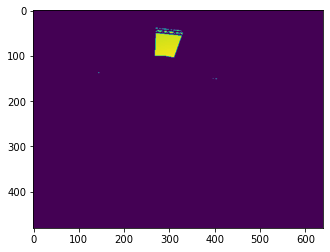

In [ ]:
images_and_depths = zip(file_list_images, file_list_depths)


In [ ]:
images.shape

NameError: name 'images' is not defined

(array([[480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([1.20996094e+00, 1.71468896e+03, 3.42816797e+03, 5.14164697e+03,
        6.85512598e+03, 8.56860547e+03, 1.02820840e+04, 1.19955625e+04,
        1.37090420e+04, 1.54225215e+04, 1.71360000e+04], dtype=float32),
 <a list of 640 BarContainer objects>)

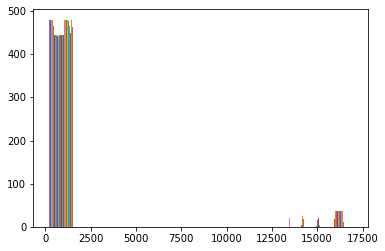

In [ ]:
plt.hist(dataset_depths[70])